# Libraries

In [82]:
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

In [ ]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head(3))
print()
##print(testingSet.head())

print()

##print(trainingSet.describe())

##trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
##plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [86]:
import re
import pandas as pd

def add_features_to(df):

    # Helpfulness Score
    df['Helpfulness'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Define expanded positive and negative words and negation pattern
    positive_words = r'\b(?:good|great|excellent|fantastic|amazing|love|awesome|wonderful|perfect|positive|happy|delightful|enjoyable|brilliant|cool)\b'
    negative_words = r'\b(?:bad|terrible|poor|awful|dislike|hate|horrible|disappointing|negative|sad|unhappy|dreadful|worst|annoying|lame)\b'
    negation_pattern = r'\b(?:not|never|no|none)\b'

    # Precompile regex patterns for efficiency
    positive_regex = re.compile(positive_words, re.IGNORECASE)
    negative_regex = re.compile(negative_words, re.IGNORECASE)
    negation_regex = re.compile(negation_pattern, re.IGNORECASE)

    # Function to detect positive and negative word counts, considering negations
    def detect_sentiment_indicators(text):
        text = str(text).lower()  # Convert text to lowercase for consistent matching

        # Find all positive and negative words
        positive_matches = positive_regex.findall(text)
        negative_matches = negative_regex.findall(text)

        # Detect negated positive and negative phrases
        negated_positive_matches = re.findall(negation_pattern + r'\s+' + positive_words, text)
        negated_negative_matches = re.findall(negation_pattern + r'\s+' + negative_words, text)

        # Calculate final indicators, adjusting for negations
        positive_indicator = len(positive_matches) - len(negated_positive_matches)
        negative_indicator = len(negative_matches) - len(negated_negative_matches)

        return positive_indicator, negative_indicator
    
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    import nltk

    nltk.download('vader_lexicon')
    sia = SentimentIntensityAnalyzer()

    # Apply the function to each row in the DataFrame
    sentiment_indicators = df['Text'].fillna('').apply(detect_sentiment_indicators)
    df['positive_indicator'], df['negative_indicator'] = zip(*sentiment_indicators)

    # Review length and summary length
    df['review_length'] = df['Text'].apply(lambda x: len(str(x).split()))
    df['summary_length'] = df['Summary'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

    # Sentiment polarity using VADER
    df['polarity'] = df['Text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

    return df

import pandas as pd
from os.path import exists

# Load the feature extracted files if they already exist
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the training DataFrame
    train = add_features_to(trainingSet)

    # Load test.csv, which includes Id and an empty Score column
    test = pd.read_csv('./data/test.csv')

    # Merge on 'Id' to bring feature columns from `train` into `test`
    X_submission = pd.merge(test[['Id']], train.drop(columns=['Score']), on='Id', how='left')

    # X_train contains only rows from `train` where Score is not null
    X_train = train[train['Score'].notnull()]

    # Save processed files for future use
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

print("Feature extraction and file saving completed.")



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tianxiaoshan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Feature extraction and file saving completed.


# Model Creation

In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import accuracy_score
import scipy.sparse as sp

# Sample 20% of the data from the training set
sampled_df = trainingSet.sample(frac=0.2, random_state=42)

# Apply feature engineering to add the new features
sampled_df = add_features_to(sampled_df)

# Vectorize the 'Text' column using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
train_text_tfidf = tfidf.fit_transform(sampled_df['Text'].fillna(''))

# Combine TF-IDF features with all relevant numeric features from add_features_to
numeric_features = sampled_df[['Helpfulness', 'review_length', 'summary_length', 
                               'positive_indicator', 'negative_indicator', 'polarity']].fillna(0)

# Combine TF-IDF and numeric features into a final feature matrix
X = sp.hstack([train_text_tfidf, numeric_features])

# Target variable
y = sampled_df['Score'].fillna(0)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=500,  # Number of estimators
    learning_rate=0.1, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8
)

xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'XGBoost Accuracy on Sampled Data with New Features: {accuracy}')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tianxiaoshan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


XGBoost Accuracy on Sampled Data with New Features: 0.5548437453977791


# Model Evaluation

Accuracy on validation set =  0.5548437453977791


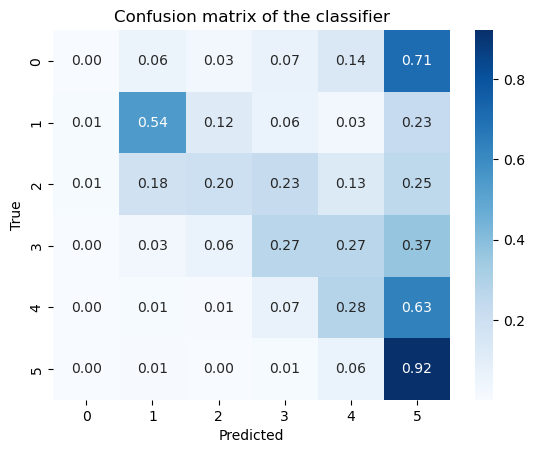

In [91]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate your model on the validation set
print("Accuracy on validation set = ", accuracy_score(y_val, y_pred))

# Plot a confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f")
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Creating Submission File

In [92]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

# Load X_submission.csv and apply feature engineering
X_submission = pd.read_csv("./data/X_submission.csv")

# Ensure 'Text' and 'Summary' columns in X_submission are strings for consistency
X_submission['Text'] = X_submission['Text'].astype(str)
X_submission['Summary'] = X_submission['Summary'].astype(str)

# Apply feature engineering using add_features_to function to ensure all required features are present
X_submission = add_features_to(X_submission)

# Vectorize the 'Text' column using the already fitted TF-IDF vectorizer
submission_text_tfidf = tfidf.transform(X_submission['Text'].fillna(''))

# Prepare numeric features (ensure the columns are present)
numeric_features_submission = X_submission[[
    'Helpfulness', 'review_length', 'summary_length', 
    'contains_positive_words', 'contains_negative_words', 
    'polarity'
]].fillna(0)

# Combine TF-IDF and numeric features using hstack
X_test = hstack([submission_text_tfidf, numeric_features_submission.values])

# Predict using the trained model
y_test_pred = xgb_model.predict(X_test)

# Round the predictions to the nearest integer between 1 and 5
y_test_pred_rounded = np.clip(np.round(y_test_pred), 1, 5)

# Create the submission DataFrame with 'Id' and 'Score'
X_submission['Score'] = y_test_pred_rounded
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

print("submission.csv created successfully.")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tianxiaoshan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


submission.csv created successfully.
